<a href="https://colab.research.google.com/github/DanilDelegator/data-science-workshop/blob/main/Global_Wheat_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Global Wheat Detection**
## **Introduction**
This notebook was created by Avraham Toubi and Danil Delegator as part of the Data Science workshop at the Open University of Israel, Summer of 2024.

As we were searching for a topic for the workshop, we came across many interesting databases. We chose to study this database because we believe that the topic has a critical importance to the food industry and can potentially create a meaningful global impact. This research could help address global challenges like climate change and food shortage. By contributing to this field, we hope to be part of a solution that impacts millions of lives, ensuring that this necessity remains accessible to everyone.

##**The Problem**
Wheat is grown in many countries around the world and is a crucial part of many diets worldwide. Its significance as a food source and agricultural crop has made it a well-researched topic as scientists tried to understand how to grow it better and faster. This database was created as part of an attempt to help researchers measure the improvements in the field. The database is a collection of pictures of wheat fields from several countries. The wheat heads in each picture are marked in a separate file so by analyzing this database, researchers can estimate the density and size of wheat heads in various varieties.
Detecting wheat heads accurately in outdoor field pictures is a significant challenge. Dense planting in fields often causes overlapping wheat heads, and wind can blur photographs, making it hard to identify individual heads. Furthermore, variations in maturity, color, genotype, and head orientation add complexity. Additionally, wheat is grown globally under diverse conditions, with differing varieties, planting patterns, soil and other environmental factors. A good model this database must overcome regional biases and generalize effectively across all these varying conditions.

###Here is an example of a collage of several different pictures in the database:

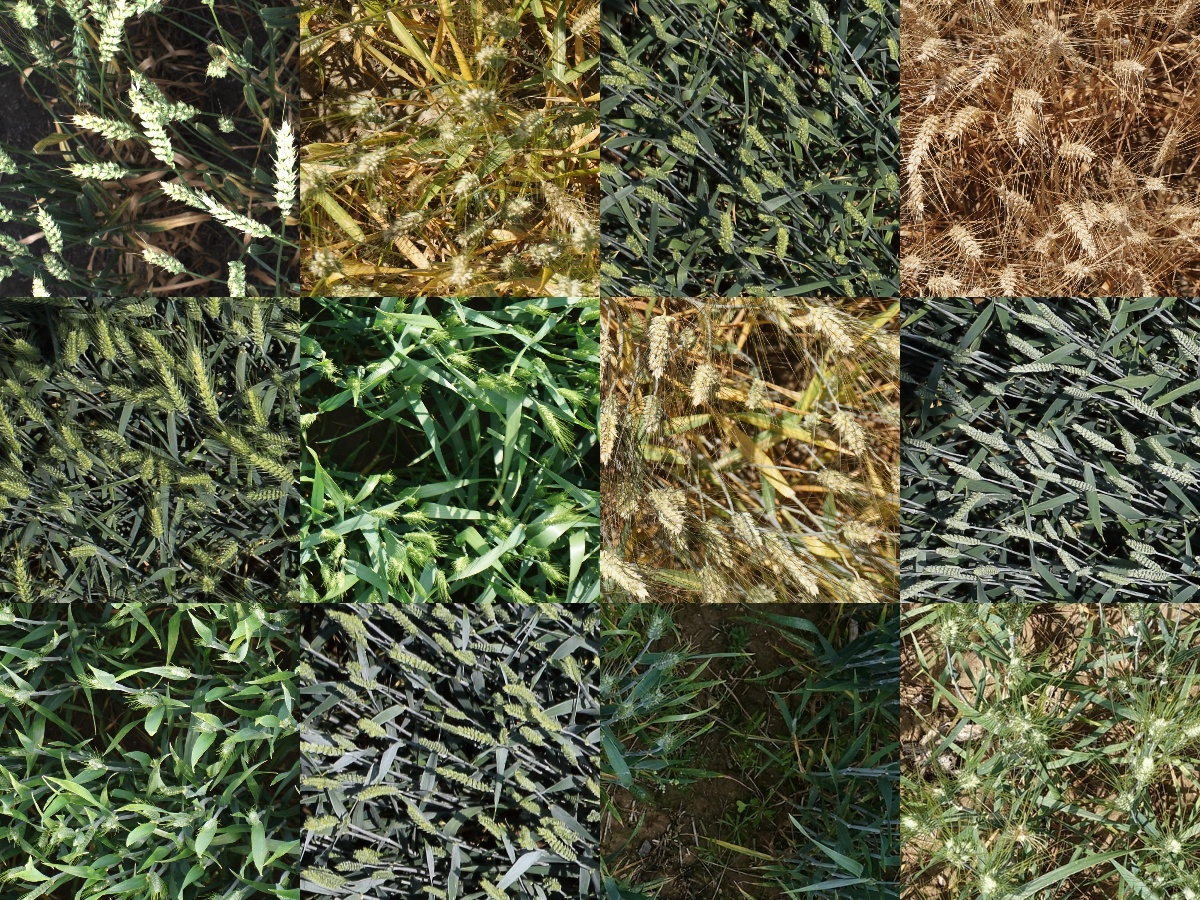

As you can see, the pictures differ in many aspects which will probably give us a hard time trying to find the best algorithm to identify the wheat-heads in the picture.

In [ ]:
import ast
import os
import zipfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
import skimage.io
from tqdm import tqdm

tqdm.pandas()

Let's start by unziping the data and do a some basic analysis to understand what we are wokring with.

In [ ]:
URL = "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/19989/1160143/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1735205562&Signature=VQ3Xs5M5Zv5jnZno5hIFd9XQIJZ1i1YvhVpKagpSwE5MKHPtZoyIHxN64RcmMl17XCoMx0emeCujMJrKpZlaq1S3cZmrUK7Q%2FK6kDFu2ydiQ8TOp4UPh9mNkvHlvJSyFDu1YiY%2Bmmy9%2BXyJEe%2FpObMD3yGh%2FgaPvXnH%2F9%2BePTPnxDChY1RNeZwMzhI58FYgj6jpMSrOQpW9wZqmRE5uIm6PXFCgYO7%2Bs%2FSl%2FP0oiDGgI3IjH2en7I94CMgdjfbKGfBq%2F1Rl8wEPJ8QJl%2B7tQO0XhDSnUwmEmgqfQve%2BzNn2q6VUxw%2BNo9W3SyQah9MA8iA%2FOKHJCsPV01pdvYImdRA%3D%3D&response-content-disposition=attachment%3B+filename%3Dglobal-wheat-detection.zip"
FOLDER_PATH = "/content/global-wheat-detection"
ZIP_PATH = f"{FOLDER_PATH}.zip"

if not os.path.exists(FOLDER_PATH):
  urllib.request.urlretrieve(URL, ZIP_PATH)

  with zipfile.ZipFile(ZIP_PATH, 'r') as zip_file:
      zip_file.extractall(FOLDER_PATH)


First let's look at the "train.csv" data. It is a tabular data that is made up of 4 important columns:
1. image_id - the unique image ID
2. width - the width of the image
3. height - the height of the image
4. bbox - a bounding box of the wheat in the image as a Python-style list of [xmin, ymin, width, height]



In [ ]:
train = pd.read_csv(os.path.join('/content/global-wheat-detection', "train.csv"))
train.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

Let's look at the width and height distribution (grouped by source)


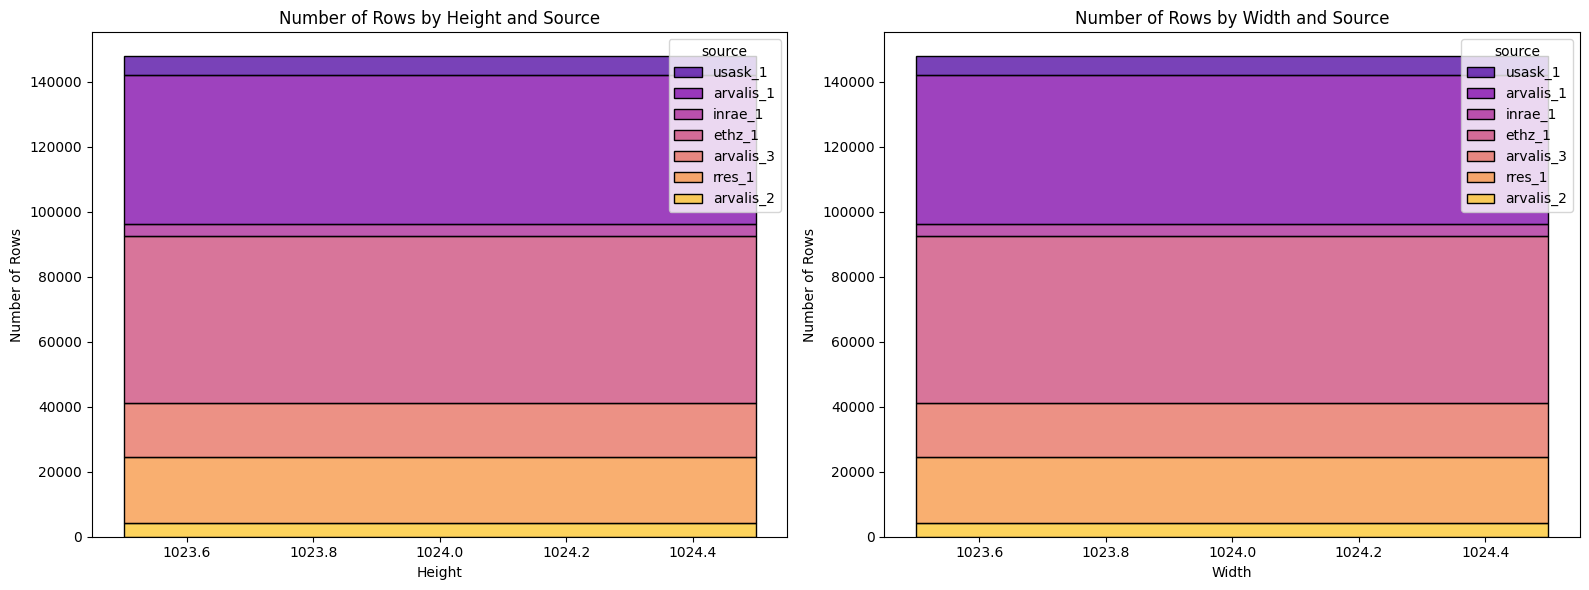

In [ ]:
# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Height
sns.histplot(data=train, x='height', hue='source', multiple="stack", ax=axes[0], palette='plasma')
axes[0].set_title('Number of Rows by Height and Source')
axes[0].set_ylabel('Number of Rows')
axes[0].set_xlabel('Height')
plt.tight_layout()

# Plot for Width
sns.histplot(data=train, x='width', hue='source', multiple="stack", ax=axes[1], palette='plasma')
axes[1].set_title('Number of Rows by Width and Source')
axes[1].set_ylabel('Number of Rows')
axes[1].set_xlabel('Width')
plt.tight_layout()

plt.show()

We can see that the image heights and widths are all 1024 pixels which makes preprocessing simpler.

Now let's look at the bbox sizes which represent the size of each wheat in the image and can be a good proxy for the "zoom" of the image (again, group by source).

In [ ]:
# Calculate a bbox_area column
BBOX_WIDTH_INDEX = 2
BBOX_HEIGHT_INDEX = 3

train['literal_bbox'] = train['bbox'].apply(ast.literal_eval)

train['bbox_area'] = train['literal_bbox'].apply(
    lambda x: x[BBOX_WIDTH_INDEX] * x[BBOX_HEIGHT_INDEX]
)

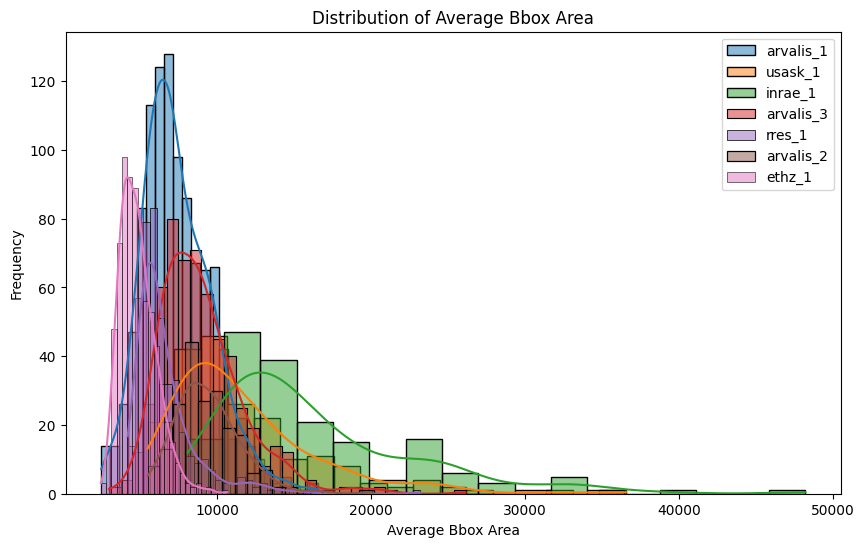

In [ ]:
# Calculate the average bbox area and multiply by the number of rows per image_id
df_grouped = train.groupby(['image_id', 'source']).agg(
    avg_bbox_area = pd.NamedAgg(column='bbox_area', aggfunc='mean'),
).reset_index()


plt.figure(figsize=(10, 6))
sources = df_grouped['source'].unique()
for source in sources:
    subset = df_grouped[df_grouped['source'] == source]
    sns.histplot(subset['avg_bbox_area'], label=source, kde=True)

plt.title('Distribution of Average Bbox Area')
plt.xlabel('Average Bbox Area')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Let's do the same for the number of wheats in each iamge (grouped by source)

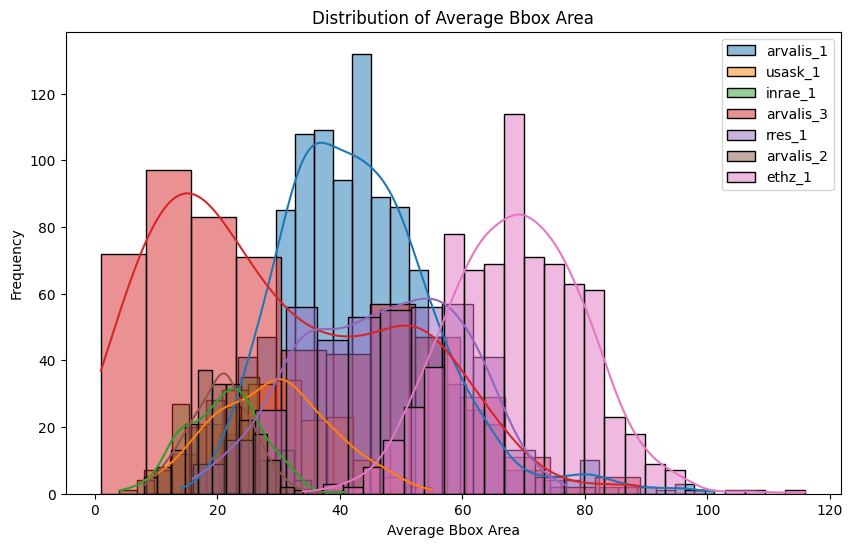

In [ ]:
# Calculate the average bbox area and multiply by the number of rows per image_id
df_grouped = train.groupby(['image_id', 'source']).agg(
    wheat_count = pd.NamedAgg(column='bbox', aggfunc='count'),
).reset_index()


# Plotting
plt.figure(figsize=(10, 6))
sources = df_grouped['source'].unique()
for source in sources:
    subset = df_grouped[df_grouped['source'] == source]
    sns.histplot(subset['wheat_count'], label=source, kde=True)

plt.title('Distribution of Average Bbox Area')
plt.xlabel('Average Bbox Area')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Now we can combine the 2 data points and figure out the density of wheats in each image (assuming wheats are ruffly the same real-life size)

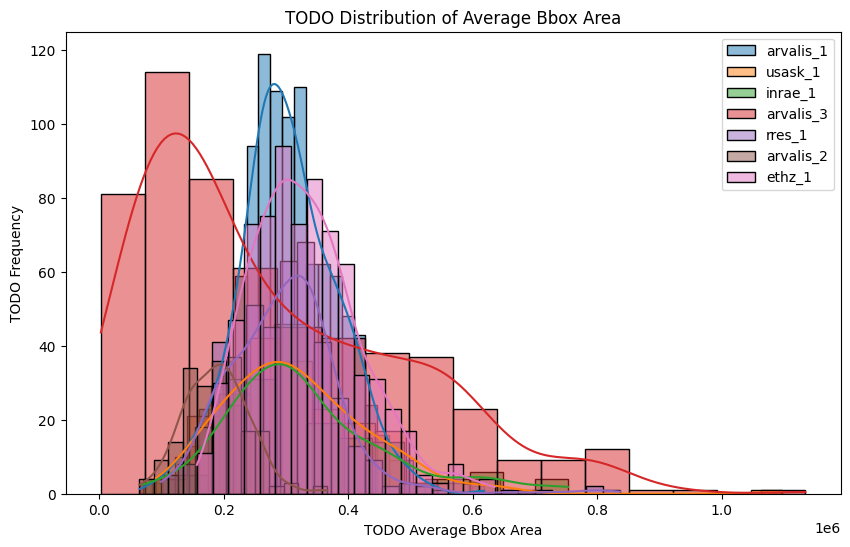

In [ ]:
# Calculate the average bbox area and multiply by the number of rows per image_id
df_grouped = train.groupby(['image_id', 'source']).agg(
    avg_bbox_area = pd.NamedAgg(column='bbox_area', aggfunc='mean'),
    wheat_count = pd.NamedAgg(column='bbox', aggfunc='count'),
).reset_index()

df_grouped['multiplied_area'] = df_grouped['avg_bbox_area'] * df_grouped['wheat_count']

# Plotting
plt.figure(figsize=(10, 6))
sources = df_grouped['source'].unique()
for source in sources:
    subset = df_grouped[df_grouped['source'] == source]
    sns.histplot(subset['multiplied_area'], label=source, kde=True)

plt.title('TODO Distribution of Average Bbox Area')
plt.xlabel('TODO Average Bbox Area')
plt.ylabel('TODO Frequency')
plt.legend()
plt.show()

Now let's load the actual image data to a column in the dataframe. Since there are multiple rows for each image, if we load the image in a straight forward way, we will round out of memory on our machine but using a cache will allow us to load the actual image into memory only once.

In [ ]:
image_cache = {}

def load_image(image_id):
  if image_id in image_cache:
    return image_cache[image_id]
  else:
    image_data = skimage.io.imread(os.path.join(FOLDER_PATH, 'train', f'{image_id}.jpg'))
    image_cache[image_id] = image_data
    return image_data

train['raw_image'] = train['image_id'].apply(load_image)
train

image_id  width  height                         bbox     source  \
0       b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]    usask_1   
1       b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]    usask_1   
2       b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]    usask_1   
3       b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]    usask_1   
4       b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]    usask_1   
...           ...    ...     ...                          ...        ...   
147788  5e0747034   1024    1024    [64.0, 619.0, 84.0, 95.0]  arvalis_2   
147789  5e0747034   1024    1024  [292.0, 549.0, 107.0, 82.0]  arvalis_2   
147790  5e0747034   1024    1024  [134.0, 228.0, 141.0, 71.0]  arvalis_2   
147791  5e0747034   1024    1024   [430.0, 13.0, 184.0, 79.0]  arvalis_2   
147792  5e0747034   1024    1024   [875.0, 740.0, 94.0, 61.0]  arvalis_2   

                       literal_bbox  bbox_area  \
0        [834.0, 222.0, 56.0, 36.0]     2016.0   
1       [226.0, 548.0, 130.0, 58.0]     7540.0   
2       [377.0, 504.0, 74.0, 160.0]    11840.0   
3       [834.0, 95.0, 109.0, 107.0]    11663.0   
4       [26.0, 144.0, 124.0, 117.0]    14508.0   
...                             ...        ...   
147788    [64.0, 619.0, 84.0, 95.0]     7980.0   
147789  [292.0, 549.0, 107.0, 82.0]     8774.0   
147790  [134.0, 228.0, 141.0, 71.0]    10011.0   
147791   [430.0, 13.0, 184.0, 79.0]    14536.0   
147792   [875.0, 740.0, 94.0, 61.0]     5734.0   

                                                raw_image  
0       [[[26, 24, 25], [30, 28, 29], [36, 34, 35], [4...  
1       [[[26, 24, 25], [30, 28, 29], [36, 34, 35], [4...  
2       [[[26, 24, 25], [30, 28, 29], [36, 34, 35], [4...  
3       [[[26, 24, 25], [30, 28, 29], [36, 34, 35], [4...  
4       [[[26, 24, 25], [30, 28, 29], [36, 34, 35], [4...  
...                                                   ...  
147788  [[[129, 138, 93], [129, 138, 91], [141, 147, 1...  
147789  [[[129, 138, 93], [129, 138, 91], [141, 147, 1...  
147790  [[[129, 138, 93], [129, 138, 91], [141, 147, 1...  
147791  [[[129, 138, 93], [129, 138, 91], [141, 147, 1...  
147792  [[[129, 138, 93], [129, 138, 91], [141, 147, 1...  

[147793 rows x 8 columns]

Let's make sure it worked by looking at the first 20 images from the dataframe

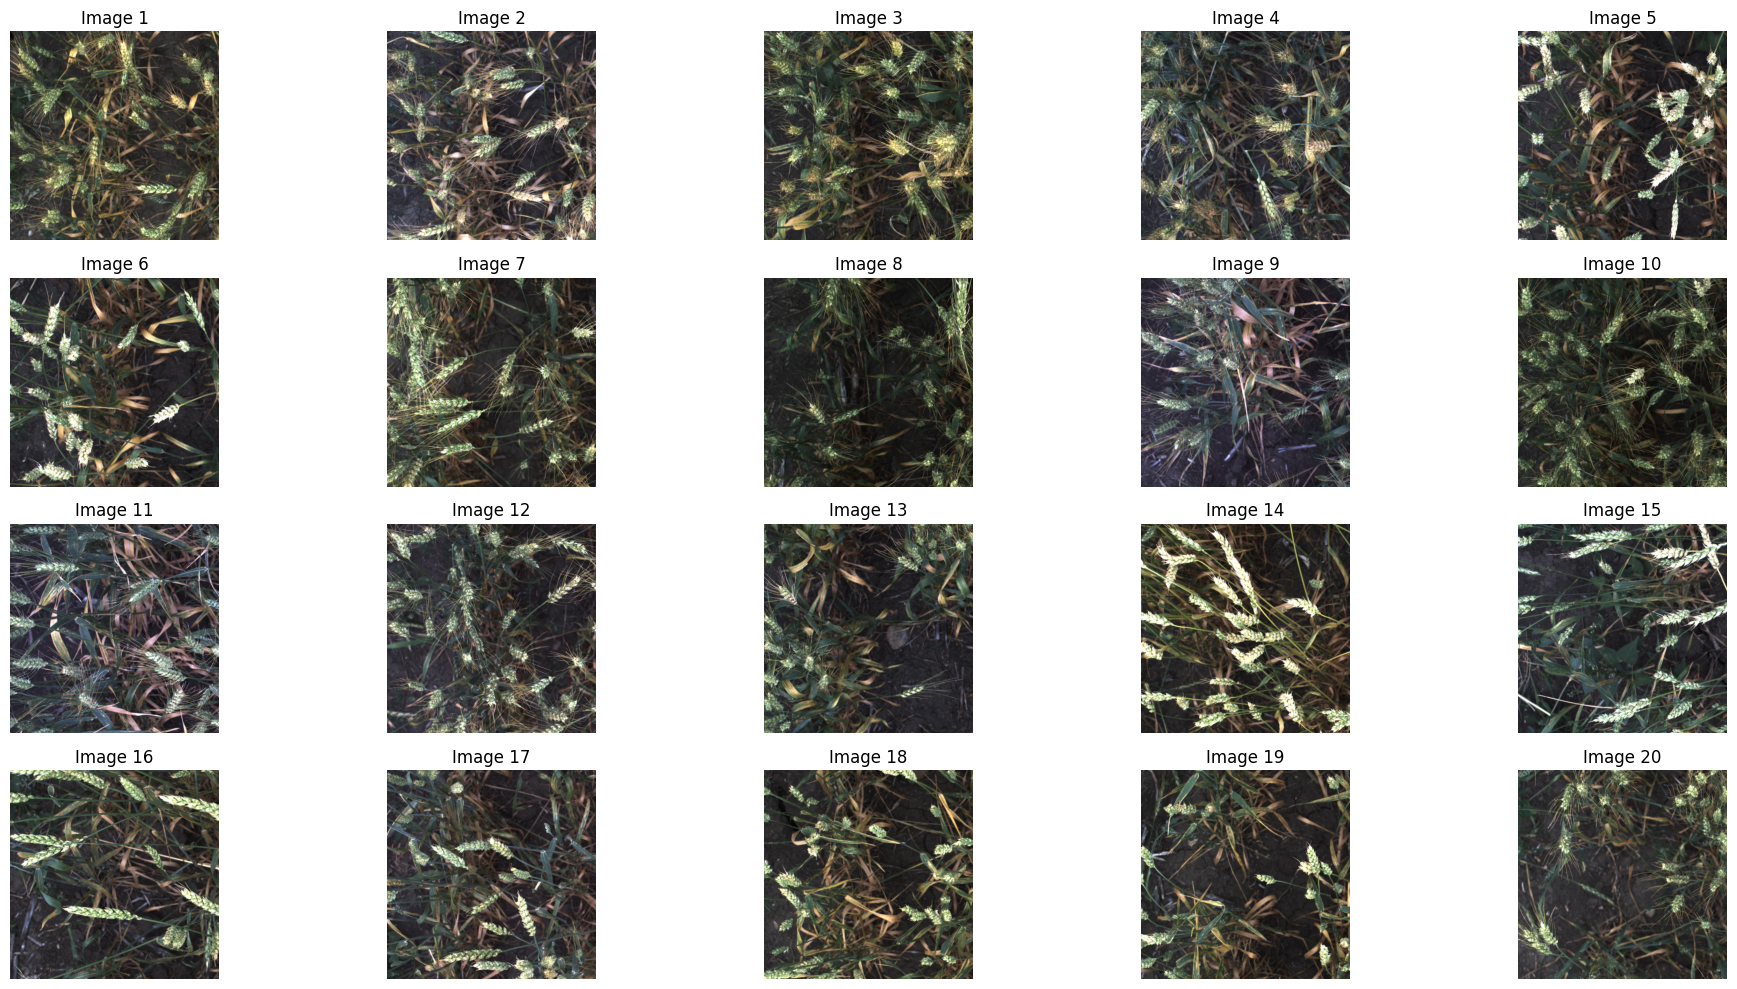

In [ ]:
unique_df = train.groupby('image_id').head(1).reset_index(drop=True)
first_20_images = unique_df.head(20)

fig, axes = plt.subplots(4, 5, figsize=(20, 10))
axes = axes.flatten()

for i in range(20):
    axes[i].imshow(first_20_images.iloc[i]['raw_image'])
    axes[i].set_title(f"Image {i + 1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Now let's load the wheat outlined by the bbox.

In [ ]:
def load_wheat_image(col):
    xmin, ymin, width, height = map(int, col["literal_bbox"])
    return col['raw_image'][ymin:ymin + height, xmin:xmin + width]

train['raw_wheat_image'] = train.apply(load_wheat_image, axis=1)
train

image_id  width  height                         bbox     source  \
0       b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]    usask_1   
1       b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]    usask_1   
2       b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]    usask_1   
3       b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]    usask_1   
4       b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]    usask_1   
...           ...    ...     ...                          ...        ...   
147788  5e0747034   1024    1024    [64.0, 619.0, 84.0, 95.0]  arvalis_2   
147789  5e0747034   1024    1024  [292.0, 549.0, 107.0, 82.0]  arvalis_2   
147790  5e0747034   1024    1024  [134.0, 228.0, 141.0, 71.0]  arvalis_2   
147791  5e0747034   1024    1024   [430.0, 13.0, 184.0, 79.0]  arvalis_2   
147792  5e0747034   1024    1024   [875.0, 740.0, 94.0, 61.0]  arvalis_2   

                       literal_bbox  bbox_area  \
0        [834.0, 222.0, 56.0, 36.0]     2016.0   
1       [226.0, 548.0, 130.0, 58.0]     7540.0   
2       [377.0, 504.0, 74.0, 160.0]    11840.0   
3       [834.0, 95.0, 109.0, 107.0]    11663.0   
4       [26.0, 144.0, 124.0, 117.0]    14508.0   
...                             ...        ...   
147788    [64.0, 619.0, 84.0, 95.0]     7980.0   
147789  [292.0, 549.0, 107.0, 82.0]     8774.0   
147790  [134.0, 228.0, 141.0, 71.0]    10011.0   
147791   [430.0, 13.0, 184.0, 79.0]    14536.0   
147792   [875.0, 740.0, 94.0, 61.0]     5734.0   

                                                raw_image  \
0       [[[26, 24, 25], [30, 28, 29], [36, 34, 35], [4...   
1       [[[26, 24, 25], [30, 28, 29], [36, 34, 35], [4...   
2       [[[26, 24, 25], [30, 28, 29], [36, 34, 35], [4...   
3       [[[26, 24, 25], [30, 28, 29], [36, 34, 35], [4...   
4       [[[26, 24, 25], [30, 28, 29], [36, 34, 35], [4...   
...                                                   ...   
147788  [[[129, 138, 93], [129, 138, 91], [141, 147, 1...   
147789  [[[129, 138, 93], [129, 138, 91], [141, 147, 1...   
147790  [[[129, 138, 93], [129, 138, 91], [141, 147, 1...   
147791  [[[129, 138, 93], [129, 138, 91], [141, 147, 1...   
147792  [[[129, 138, 93], [129, 138, 91], [141, 147, 1...   

                                          raw_wheat_image  
0       [[[47, 46, 44], [43, 42, 40], [41, 40, 38], [4...  
1       [[[81, 70, 50], [81, 73, 52], [80, 75, 53], [8...  
2       [[[74, 63, 57], [74, 61, 55], [69, 56, 48], [6...  
3       [[[49, 53, 54], [55, 57, 54], [52, 53, 47], [4...  
4       [[[97, 89, 76], [80, 70, 60], [71, 61, 52], [8...  
...                                                   ...  
147788  [[[113, 132, 68], [109, 128, 64], [95, 115, 52...  
147789  [[[95, 108, 82], [71, 81, 56], [42, 52, 25], [...  
147790  [[[112, 118, 72], [109, 117, 70], [113, 122, 7...  
147791  [[[103, 124, 83], [98, 119, 78], [111, 132, 93...  
147792  [[[107, 109, 60], [81, 83, 33], [84, 88, 37], ...  

[147793 rows x 9 columns]

Now let's make sure what we did actually worked

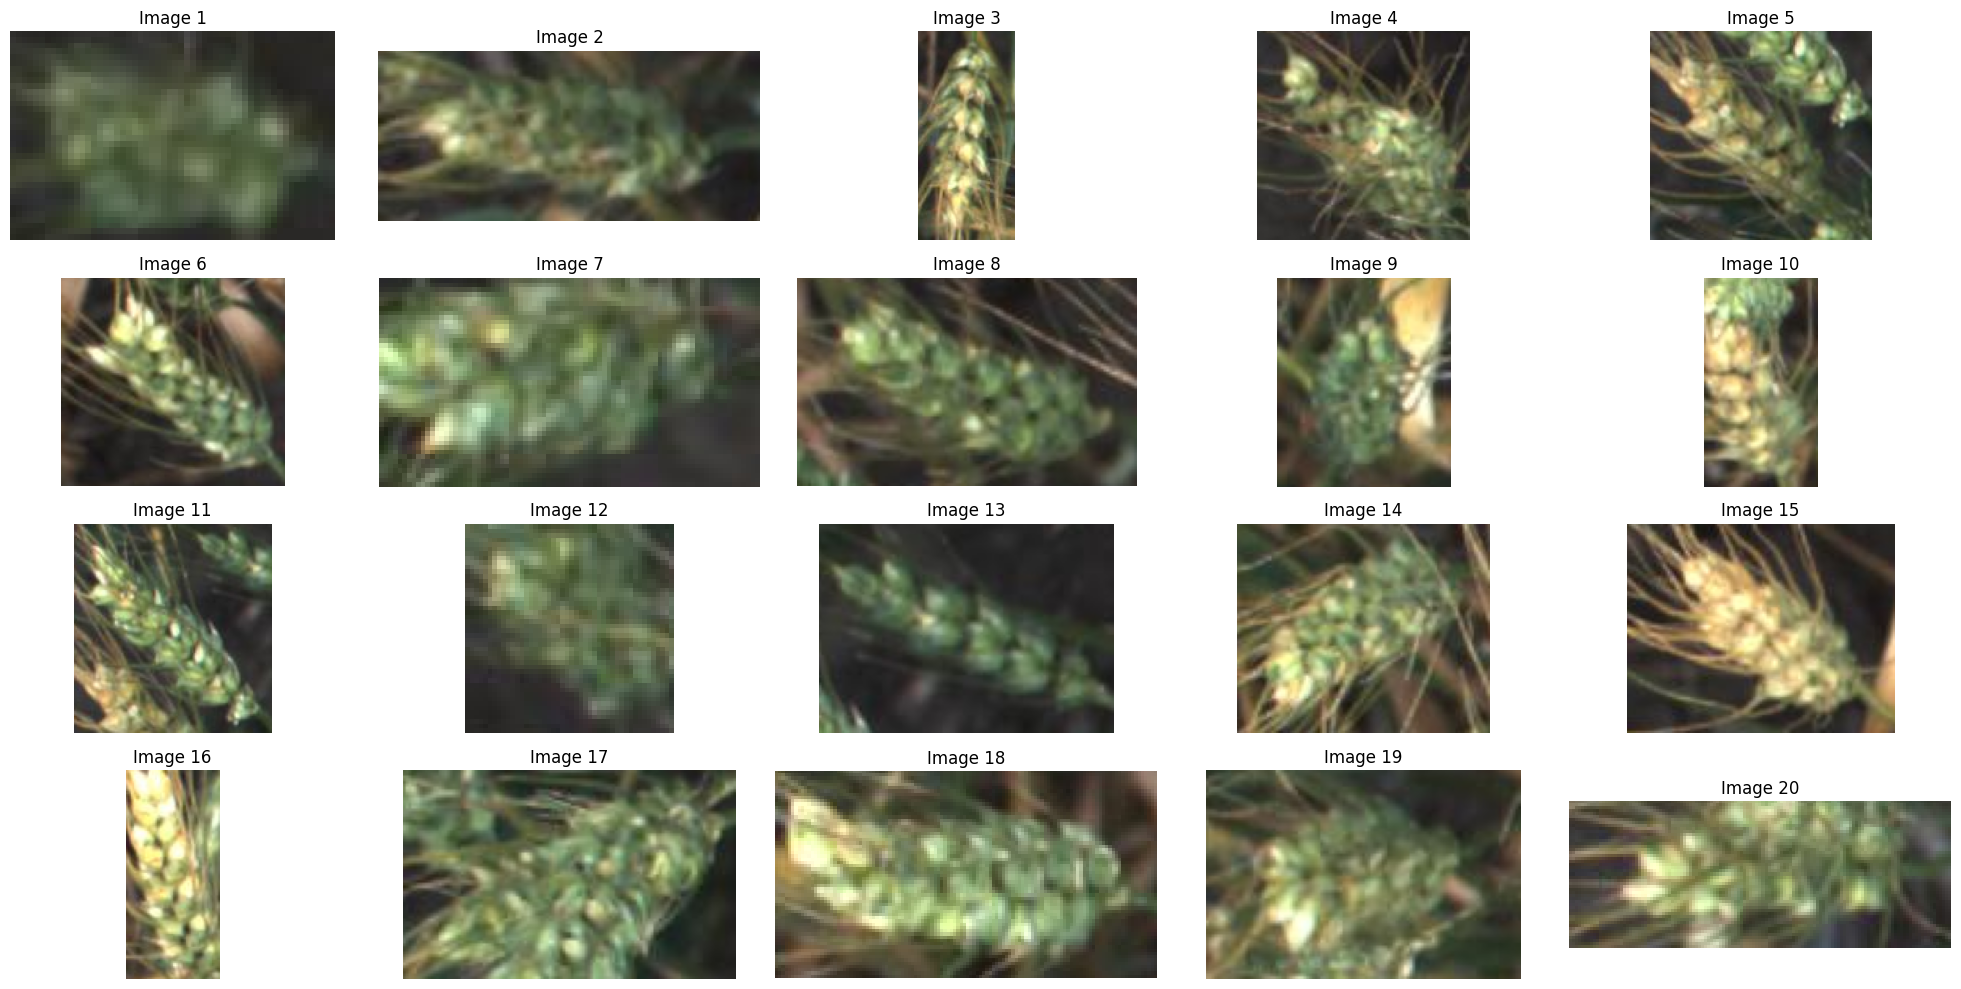

In [ ]:
num_images_to_show = min(20, len(train))

fig, axes = plt.subplots(4, 5, figsize=(20, 10))
axes = axes.flatten()

for i in range(num_images_to_show):
    axes[i].imshow(train.iloc[i]['raw_wheat_image'])
    axes[i].set_title(f"Image {i + 1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Let's start by creating a masked image for each wheat.

In [ ]:
# prompt: for each row create a raw_image_mask where the whole picture is white (0) and only the space specified by the "literal_bbox" is blacked out (1). Use the same cache technic like when creating the raw_image above..

import numpy as np

image_mask_cache = {}

def create_mask(row):
    image_id = row['image_id']
    if image_id in image_mask_cache:
        return image_mask_cache[image_id]

    image = row['raw_image']
    xmin, ymin, width, height = map(int, row["literal_bbox"])
    mask = np.zeros_like(image)
    if len(image.shape) == 3:
      mask = np.zeros_like(image[:,:,0]) #grayscale
    mask[ymin:ymin+height,xmin:xmin+width] = 1
    image_mask_cache[image_id] = mask
    return mask

train['raw_image_mask'] = train.progress_apply(create_mask, axis=1)

100%|██████████| 147793/147793 [00:02<00:00, 66017.11it/s]


In [ ]:
# grouped_df = train.groupby('image_id').agg(
#     annotations=('literal_bbox', list),
#     raw_image=('raw_image', 'first')  # Keep the first raw_image for each image_id
# ).reset_index()

In [ ]:
# def create_mask(row):
#     image = row['raw_image']
#     mask = np.zeros_like(image)
#     annotations = row['annotations']

#     for bbox in annotations:
#         xmin, ymin, width, height = map(int, bbox)
#         # Ensure bbox dimensions are within image bounds
#         xmin = max(0, xmin)
#         ymin = max(0, ymin)
#         xmax = min(image.shape[1], xmin + width)
#         ymax = min(image.shape[0], ymin + height)
#         mask[ymin:ymax, xmin:xmax] = 1  # Set mask value to 1 in the bbox region
#     return mask

# grouped_df['raw_image_masked'] = grouped_df.progress_apply(create_mask, axis=1)
# grouped_df

In [ ]:
# import matplotlib.pyplot as plt

# num_images_to_show = min(20, len(grouped_df))

# fig, axes = plt.subplots(4, 5, figsize=(20, 10))
# axes = axes.flatten()

# for i in range(num_images_to_show):
#     axes[i].imshow(grouped_df.iloc[i]['raw_image_masked'])
#     axes[i].set_title(f"Image {i + 1}")
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()

test